In [1]:
#Installing the imbalanced learn module for access to a variety of over-sampling methods

#!pip install imbalanced-learn
#!pip install numpy==1.21
#!pip install lxml

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('Data/clean_gss.csv')
df.head()

,Unnamed: 0,LONELY2,SATJOB,MOREDAYS,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,AGE,MARITAL,EDUC,is_si,marital_cat,MOREWEEKS,Age Group
0,3,2.0,1.0,2.0,1.0,1.0,1.0,4.0,3.0,63.0,1.0,4,0,1,1,4
1,6,3.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,59.0,3.0,3,1,0,1,3
2,7,1.0,1.0,24.0,1.0,2.0,3.0,4.0,5.0,43.0,5.0,2,0,0,4,2
3,9,3.0,2.0,3.0,1.0,2.0,3.0,4.0,1.0,55.0,1.0,2,1,1,1,3
4,11,3.0,2.0,6.0,1.0,3.0,3.0,2.0,1.0,34.0,4.0,3,1,0,1,2


In [4]:
# Getting rid of redundant columns from initial dataframe

gss= df[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','marital_cat', 'EDUC', 'is_si', 'MOREWEEKS', 'Age Group']]
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,marital_cat,EDUC,is_si,MOREWEEKS,Age Group
0,1.0,1.0,1.0,1.0,4.0,3.0,1,4,0,1,4
1,1.0,1.0,3.0,2.0,3.0,2.0,0,3,1,1,3
2,1.0,1.0,2.0,3.0,4.0,5.0,0,2,0,4,2
3,2.0,1.0,2.0,3.0,4.0,1.0,1,2,1,1,3
4,2.0,1.0,3.0,3.0,2.0,1.0,0,3,1,1,2


<Axes: >

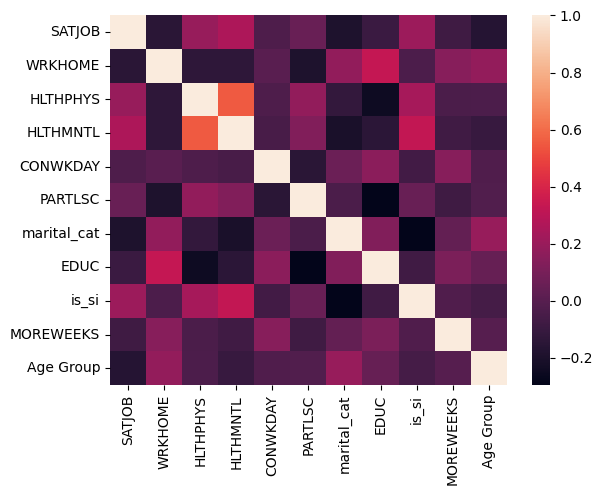

In [5]:
# Checking for multicollinearity- looks good

corr = gss.corr()
sns.heatmap(corr)

In [6]:
# Marital status is the only nominal categorical variable in this dataframe. Using get_dummies to one-hot encode and
# dropping first level of marital status: a zero for marital_2, marital_3, marital_4, and marital_5 implies row belongs
# to marital_1. The rest of the variables are ordinal and attempting to run logit with variables as-is.

gss= pd.get_dummies(gss, columns= ['marital_cat'], prefix= 'Marital', drop_first= True)
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,EDUC,is_si,MOREWEEKS,Age Group,Marital_1
0,1.0,1.0,1.0,1.0,4.0,3.0,4,0,1,4,1
1,1.0,1.0,3.0,2.0,3.0,2.0,3,1,1,3,0
2,1.0,1.0,2.0,3.0,4.0,5.0,2,0,4,2,0
3,2.0,1.0,2.0,3.0,4.0,1.0,2,1,1,3,1
4,2.0,1.0,3.0,3.0,2.0,1.0,3,1,1,2,0


In [7]:
# Starting to split data to prepare for modeling

X= gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS', 'Age Group', 'Marital_1' ]]
y= gss['is_si']

In [8]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_X, os_y= os.fit_resample(X_train, y_train)

In [9]:
# Verifying we now have 50/50 isolated to non-isolated for training data

os_y.value_counts()

1    364
0    364
Name: is_si, dtype: int64

In [10]:
# SATJOB, HLTHPHYS, PARTLSC, MARITAL_2, MARITAL_5 all have p-value above 0.05 lacking statistical significance

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_X)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.556043
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  728
Model:                          Logit   Df Residuals:                      718
Method:                           MLE   Df Model:                            9
Date:                Tue, 04 Apr 2023   Pseudo R-squ.:                  0.1978
Time:                        20:31:09   Log-Likelihood:                -404.80
converged:                       True   LL-Null:                       -504.61
Covariance Type:            nonrobust   LLR p-value:                 3.974e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB         0.1849      0.114      1.624      0.104      -0.038       0.408
WRKHOME       -0.1737      0.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_X, os_y)
y_pred = sk_logit.predict(X_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

Accuracy on test set:0.72


In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.73      0.80       156
           1       0.46      0.71      0.56        51

    accuracy                           0.72       207
   macro avg       0.67      0.72      0.68       207
weighted avg       0.78      0.72      0.74       207



In [15]:
for age_group in gss['Age Group'].unique():
    age = gss.loc[gss['Age Group']== age_group]
    
    # Starting to split data to prepare for modeling
    
    #'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0'
    X= age[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS','Marital_1']]
    y= age['is_si']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

    # Resampling only the training data
    os= SMOTEN(random_state= 42)
    os_X, os_y= os.fit_resample(X_train, y_train)

    sm_logit = sm.Logit(os_y, os_X)
    result = sm_logit.fit()
    print("Age Group:{:.2f}".format(age_group))
    print(result.summary())

    sk_logit = LogisticRegression()
    sk_logit.fit(os_X, os_y)
    y_pred = sk_logit.predict(X_test)
    print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

#Saving summary data to a dataframe for plots
    if age_group==1.0:
        summary_df1 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==2.0:
        summary_df2 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==3.0:
        summary_df3 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]

    if age_group==4.0:
        summary_df4 = pd.read_html(result.summary().tables[1].as_html(), header=0, index_col=0)[0]


    

Optimization terminated successfully.
         Current function value: 0.366265
         Iterations 7
Age Group:4.00
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  104
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            8
Date:                Tue, 04 Apr 2023   Pseudo R-squ.:                  0.4716
Time:                        20:36:40   Log-Likelihood:                -38.092
converged:                       True   LL-Null:                       -72.087
Covariance Type:            nonrobust   LLR p-value:                 1.233e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB        -0.6111      0.548     -1.114      0.265      -1.686       0.464
WRKHOME       

In [37]:
#Create a new list to hold data that will be used for plotting
summary_plot = []

#Add a new column in each summary dataframe that indicates the Age group of the dataframe
summary_df1['Age Group'] = 1
summary_df2['Age Group'] = 2
summary_df3['Age Group'] = 3
summary_df4['Age Group'] = 4

for table in [summary_df1,summary_df2,summary_df3,summary_df4]:
    #Track the index
    index= 0
    for row in table['P>|z|']:
        
        if row <= .05:
            summary_plot.append(table.iloc[index])
        index+=1
       

In [39]:
plot_data = pd.DataFrame(summary_plot)
plot_data

,coef,std err,z,P>|z|,[0.025,0.975],Age Group
HLTHPHYS,0.6101,0.237,2.569,0.010,0.145,1.076,1.0
PARTLSC,-0.3966,0.132,-3.016,0.003,-0.654,-0.139,1.0
MOREWEEKS,-0.5286,0.242,-2.188,0.029,-1.002,-0.055,1.0
Marital_1,-3.4381,1.162,-2.960,0.003,-5.715,-1.162,1.0
WRKHOME,-0.2769,0.107,-2.584,0.010,-0.487,-0.067,2.0
HLTHMNTL,0.4365,0.197,2.221,0.026,0.051,0.822,2.0
CONWKDAY,-0.2888,0.118,-2.443,0.015,-0.521,-0.057,2.0
Marital_1,-1.7287,0.322,-5.364,0.000,-2.360,-1.097,2.0
SATJOB,-1.2831,0.337,-3.808,0.000,-1.944,-0.623,3.0
WRKHOME,-0.4161,0.176,-2.359,0.018,-0.762,-0.070,3.0


In [20]:
summary_df1.columns

Index(['coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'], dtype='object')

In [17]:
summary_df2

,coef,std err,z,P>|z|,[0.025,0.975]
SATJOB,0.2974,0.201,1.477,0.140,-0.097,0.692
WRKHOME,-0.2769,0.107,-2.584,0.010,-0.487,-0.067
HLTHPHYS,0.0309,0.182,0.170,0.865,-0.325,0.387
HLTHMNTL,0.4365,0.197,2.221,0.026,0.051,0.822
CONWKDAY,-0.2888,0.118,-2.443,0.015,-0.521,-0.057
PARTLSC,-0.0550,0.100,-0.548,0.584,-0.252,0.142
EDUC,0.2586,0.135,1.912,0.056,-0.006,0.524
MOREWEEKS,-0.2443,0.162,-1.507,0.132,-0.562,0.073
Marital_1,-1.7287,0.322,-5.364,0.000,-2.360,-1.097


In [18]:
summary_df3

,coef,std err,z,P>|z|,[0.025,0.975]
SATJOB,-1.2831,0.337,-3.808,0.000,-1.944,-0.623
WRKHOME,-0.4161,0.176,-2.359,0.018,-0.762,-0.070
HLTHPHYS,-0.0152,0.251,-0.060,0.952,-0.508,0.478
HLTHMNTL,1.5873,0.332,4.781,0.000,0.937,2.238
CONWKDAY,-0.2873,0.144,-1.997,0.046,-0.569,-0.005
PARTLSC,0.2805,0.137,2.052,0.040,0.013,0.548
EDUC,-0.0760,0.182,-0.418,0.676,-0.432,0.280
MOREWEEKS,-0.4442,0.230,-1.935,0.053,-0.894,0.006
Marital_1,-1.5153,0.428,-3.540,0.000,-2.354,-0.676


In [19]:
summary_df4

,coef,std err,z,P>|z|,[0.025,0.975]
SATJOB,-0.6111,0.548,-1.114,0.265,-1.686,0.464
WRKHOME,0.2250,0.168,1.338,0.181,-0.105,0.555
HLTHPHYS,0.7879,0.516,1.528,0.127,-0.223,1.799
HLTHMNTL,0.5284,0.524,1.008,0.313,-0.499,1.556
CONWKDAY,-0.7550,0.244,-3.090,0.002,-1.234,-0.276
PARTLSC,-0.0063,0.230,-0.027,0.978,-0.457,0.444
EDUC,-0.1133,0.257,-0.441,0.659,-0.617,0.390
MOREWEEKS,0.1524,0.328,0.465,0.642,-0.491,0.795
Marital_1,-2.9782,0.740,-4.027,0.000,-4.428,-1.529
